In [ ]:
import pandas as pd
# Load the files
df_diffs = pd.read_csv("/content/file_level_diffs (1).csv")  # contains source_before, source_current, diff
df_rectified = pd.read_csv("/content/file_level_diffs_fix_types_rectified.csv")

In [ ]:
df_merged = pd.merge(
    df_rectified,
    df_diffs[['hash', 'filename', 'source_before', 'source_current', 'diff']],
    on=['hash', 'filename'],
    how='left'  # keeps all rows from rectified file
)

In [ ]:
df_merged.to_csv("file_lab3.csv", index=False)

In [ ]:
df = pd.read_csv("/content/file_lab3.csv")

# Check first few rows
print(df.head())

                                       hash  \
0  9a90a96e96ca0a2d89b846e5f2d626092cea3a8d   
1  9a90a96e96ca0a2d89b846e5f2d626092cea3a8d   
2  c6a61daf929ded2400e82082805817ad51539eab   
3  d0fcf873b96fe4e621ceeeb017d9c3048bdd49c3   
4  d0fcf873b96fe4e621ceeeb017d9c3048bdd49c3   

                                     message                      filename  \
0  FileUploader.onprogress event. Issue #534  examples/progress_bar_app.py   
1  FileUploader.onprogress event. Issue #534                   remi/gui.py   
2     Fixed classname in editor subclassing.              editor/editor.py   
3               BugFix Link now works again.           editor/FBD_model.py   
4               BugFix Link now works again.            editor/FBD_view.py   

        LLM_inference_fix_type        LLM_rectified_message  \
0   add missing license header   add missing license header   
1     add fileuploader example       update fileuploader.js   
2  add classname to project.py  add classname to project.py

In [ ]:
total_commits = df['hash'].nunique()
total_files = df['filename'].nunique()  # unique files across all commits

print(f"Total commits: {total_commits}")
print(f"Total files: {total_files}")

Total commits: 443
Total files: 115


In [ ]:
files_per_commit = df.groupby('hash')['filename'].count()
avg_files_per_commit = files_per_commit.mean()

print(f"Average number of modified files per commit: {avg_files_per_commit:.2f}")

Average number of modified files per commit: 1.80


In [ ]:
fix_type_distribution = df['LLM_inference_fix_type'].value_counts()
print("Distribution of fix types:\n", fix_type_distribution)

Distribution of fix types:
 LLM_inference_fix_type
add missing import                        21
fix typo in example                       14
update project.py                         13
update editor.py                          12
add missing docstring                     11
                                          ..
add bugfix for server                      1
fix typo in test_threadedhttpserver.py     1
add margin 0px to the example example      1
fix typo in test_server_port.py            1
update cell background image               1
Name: count, Length: 530, dtype: int64


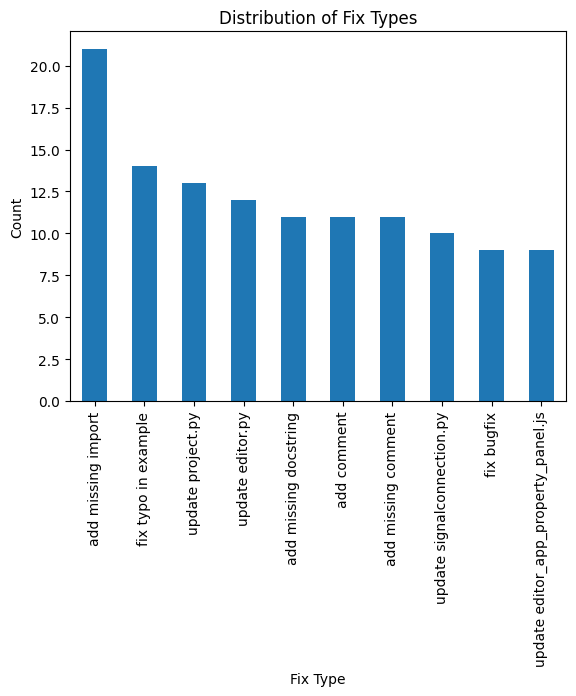

In [ ]:
import matplotlib.pyplot as plt
fix_type_distribution.head(10).plot(kind='bar', title='Distribution of Fix Types')
plt.xlabel('Fix Type')
plt.ylabel('Count')
plt.show()

In [ ]:
# Extract file extension
df['Extension'] = df['filename'].apply(lambda x: x.split('.')[-1] if '.' in x else 'none')

# Count frequency
extension_counts = df['Extension'].value_counts()
print("Most frequently modified file extensions:\n", extension_counts.head(10))

Most frequently modified file extensions:
 Extension
py           685
png           37
md            33
css           27
yml            3
ipynb          3
woff2          2
yaml           2
woff           2
gitignore      1
Name: count, dtype: int64


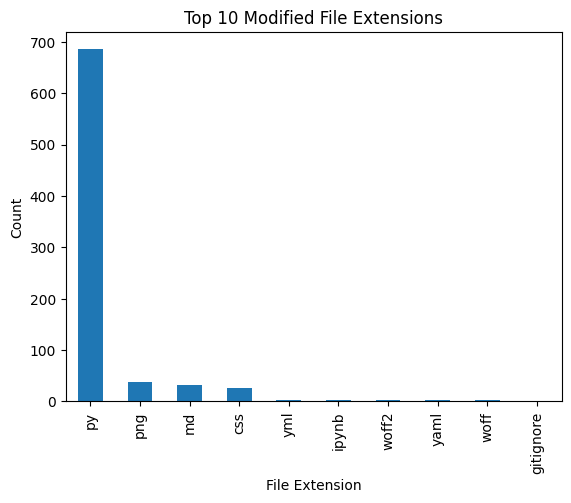

In [ ]:
extension_counts.head(10).plot(kind='bar', title='Top 10 Modified File Extensions')
plt.xlabel('File Extension')
plt.ylabel('Count')
plt.show()

In [ ]:
pip install radon

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 5.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from radon.metrics import mi_visit, h_visit
from radon.complexity import cc_visit
import warnings

In [ ]:
warnings.filterwarnings("ignore", category=SyntaxWarning)

In [ ]:
def compute_metrics(code):
    try:
        mi = mi_visit(code, True)  # Maintainability Index
        cc_list = cc_visit(code)   # list of CC per function/class
        cc_total = sum([f.complexity for f in cc_list]) if cc_list else 0
        loc_total = len(code.splitlines())
        return mi, cc_total, loc_total
    except Exception as e:
        # In case of syntax errors or empty code
        return None, None, None

In [ ]:
def safe_compute_metrics(code):
    if not isinstance(code, str):
        return None, None, None
    # Escape all backslashes
    code = code.replace("\\", "\\\\")
    return compute_metrics(code)

In [ ]:
df[['MI_Before', 'CC_Before', 'LOC_Before']] = df['source_before'].apply(lambda code: pd.Series(compute_metrics(code)))
df[['MI_After', 'CC_After', 'LOC_After']] = df['source_current'].apply(lambda code: pd.Series(compute_metrics(code)))

In [ ]:
df['MI_Change'] = df['MI_After'] - df['MI_Before']
df['CC_Change'] = df['CC_After'] - df['CC_Before']
df['LOC_Change'] = df['LOC_After'] - df['LOC_Before']

In [ ]:
print(df[['filename','MI_Before','MI_After','MI_Change',
                 'CC_Before','CC_After','CC_Change',
                 'LOC_Before','LOC_After','LOC_Change']].head())

                       filename  MI_Before   MI_After  MI_Change  CC_Before  \
0  examples/progress_bar_app.py  86.098769        NaN        NaN        5.0   
1                   remi/gui.py   0.000000   0.000000   0.000000     1067.0   
2              editor/editor.py   0.000000   0.000000   0.000000      303.0   
3           editor/FBD_model.py  52.871978  52.373357  -0.498621       43.0   
4            editor/FBD_view.py  28.564576  29.494908   0.930332      120.0   

   CC_After  CC_Change  LOC_Before  LOC_After  LOC_Change  
0       NaN        NaN        50.0        NaN         NaN  
1    1066.0       -1.0      4909.0     4885.0       -24.0  
2     303.0        0.0      1235.0     1234.0        -1.0  
3      43.0        0.0       130.0      133.0         3.0  
4     115.0       -5.0       553.0      541.0       -12.0  


In [ ]:
df_valid = df[df['MI_After'] != 0]
summary = {
    'Average_MI_Before': df['MI_Before'].mean(),
    'Average_MI_After': df['MI_After'].mean(),
    'Average_MI_Change': df['MI_Change'].mean(),
    'Average_CC_Before': df['CC_Before'].mean(),
    'Average_CC_After': df['CC_After'].mean(),
    'Average_CC_Change': df['CC_Change'].mean(),
    'Average_LOC_Before': df['LOC_Before'].mean(),
    'Average_LOC_After': df['LOC_After'].mean(),
    'Average_LOC_Change': df['LOC_Change'].mean(),
}

print("\nSummary of Structural Metrics:")
for k,v in summary.items():
    print(f"{k}: {v:.2f}")


Summary of Structural Metrics:
Average_MI_Before: 26.83
Average_MI_After: 25.63
Average_MI_Change: 0.22
Average_CC_Before: 193.31
Average_CC_After: 192.38
Average_CC_Change: -1.03
Average_LOC_Before: 981.97
Average_LOC_After: 978.07
Average_LOC_Change: -3.79


In [ ]:
df.to_csv("file_level_rectified_with_metrics.csv", index=False)

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.metrics.pairwise import cosine_similarity

# Load CodeBERT model
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model = AutoModel.from_pretrained("microsoft/codebert-base")

def compute_codebert_similarity(code1, code2):
    if not isinstance(code1, str) or not isinstance(code2, str):
        return 0.0

    # Tokenize and get embeddings
    inputs1 = tokenizer(code1, return_tensors="pt", truncation=True, max_length=512)
    inputs2 = tokenizer(code2, return_tensors="pt", truncation=True, max_length=512)

    with torch.no_grad():
        emb1 = model(**inputs1).last_hidden_state.mean(dim=1)
        emb2 = model(**inputs2).last_hidden_state.mean(dim=1)

    sim = cosine_similarity(emb1.numpy(), emb2.numpy())[0][0]
    return float(sim)

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize

def compute_token_similarity(code1, code2):
    if not isinstance(code1, str) or not isinstance(code2, str):
        return 0.0

    tokens1 = word_tokenize(code1)
    tokens2 = word_tokenize(code2)

    # BLEU score (1-gram by default)
    score = sentence_bleu([tokens1], tokens2, weights=(1, 0, 0, 0))
    return float(score)

In [ ]:
# Compute semantic similarity
df['Semantic_Similarity'] = df.apply(
    lambda row: compute_codebert_similarity(row['source_before'], row['source_current']),
    axis=1
)

# Compute token similarity
df['Token_Similarity'] = df.apply(
    lambda row: compute_token_similarity(row['source_before'], row['source_current']),
    axis=1
)

# Inspect results
print(df[['filename','Semantic_Similarity','Token_Similarity']].head())

/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

                       filename  Semantic_Similarity  Token_Similarity
0  examples/progress_bar_app.py                  0.0          0.000000
1                   remi/gui.py                  1.0          0.995443
2              editor/editor.py                  1.0          0.999356
3           editor/FBD_model.py                  1.0          0.979817
4            editor/FBD_view.py                  1.0          0.967715


In [ ]:
df.to_csv("file_level_rectified_with_all_metrics.csv", index=False)

In [ ]:
import numpy as np

# Define Semantic_class based on threshold
df['Semantic_class'] = np.where(df['Semantic_Similarity'] >= 0.80, 'Minor', 'Major')

# Define Token_class based on threshold
df['Token_class'] = np.where(df['Token_Similarity'] >= 0.75, 'Minor', 'Major')

# Create Classes_Agree column
df['Classes_Agree'] = np.where(
    df['Semantic_class'] == df['Token_class'],
    'YES',
    'NO'
)

# Inspect results
print(df[['filename', 'Semantic_Similarity', 'Token_Similarity',
                 'Semantic_class', 'Token_class', 'Classes_Agree']].head())

                       filename  Semantic_Similarity  Token_Similarity  \
0  examples/progress_bar_app.py                  0.0          0.000000   
1                   remi/gui.py                  1.0          0.995443   
2              editor/editor.py                  1.0          0.999356   
3           editor/FBD_model.py                  1.0          0.979817   
4            editor/FBD_view.py                  1.0          0.967715   

  Semantic_class Token_class Classes_Agree  
0          Major       Major           YES  
1          Minor       Minor           YES  
2          Minor       Minor           YES  
3          Minor       Minor           YES  
4          Minor       Minor           YES  


In [ ]:
# Define thresholds
semantic_threshold = 0.80
token_threshold = 0.75

# Add Semantic_class column
df["Semantic_Class"] = df["Semantic_Similarity"].apply(
    lambda x: "Minor" if x >= semantic_threshold else "Major"
)

# Add Token_class column
df["Token_Class"] = df["Token_Similarity"].apply(
    lambda x: "Minor" if x >= token_threshold else "Major"
)

# Add Classes_Agree column
df["Classes_Agree"] = df.apply(
    lambda row: "YES" if row["Semantic_Class"] == row["Token_Class"] else "NO",
    axis=1
)

# Display the updated table
print(df.head())

# Save final table
df.to_csv("file_level_rectified_with_all_metrics_final.csv", index=False)

                                       hash  \
0  9a90a96e96ca0a2d89b846e5f2d626092cea3a8d   
1  9a90a96e96ca0a2d89b846e5f2d626092cea3a8d   
2  c6a61daf929ded2400e82082805817ad51539eab   
3  d0fcf873b96fe4e621ceeeb017d9c3048bdd49c3   
4  d0fcf873b96fe4e621ceeeb017d9c3048bdd49c3   

                                     message                      filename  \
0  FileUploader.onprogress event. Issue #534  examples/progress_bar_app.py   
1  FileUploader.onprogress event. Issue #534                   remi/gui.py   
2     Fixed classname in editor subclassing.              editor/editor.py   
3               BugFix Link now works again.           editor/FBD_model.py   
4               BugFix Link now works again.            editor/FBD_view.py   

        LLM_inference_fix_type        LLM_rectified_message  \
0   add missing license header   add missing license header   
1     add fileuploader example       update fileuploader.js   
2  add classname to project.py  add classname to project.py